In [1]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from helpers import create_df
from helpers import get_peaks_and_valleys
from helpers import plot_df
from helpers import get_num_reps
from helpers import smooth_and_resample
from helpers import segment_into_reps
from helpers import add_features

from tcn import TCN
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GRU
from mpl_toolkits.mplot3d import Axes3D



2025-12-10 18:33:18.718684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-10 18:30:12.688510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 18:30:15.240944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# 0 = bicep curl, 1 = shoulder press, 2 = row, 3 = rdl, 4 = squat 
training_files = {"../data2/bicep_curl/bicep_adam_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_mike_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv": 0, 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv": 1, 
                  "../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv": 1,
                  "../data2/row/row_adam_set1_reps10_1.csv": 2, 
                  "../data2/row/row_andrew_set1_reps10_1.csv": 2, 
                  "../data2/row/row_anuj_set1_rep10_1.csv": 2, 
                  "../data2/row/row_jake_set1_reps12_1.csv": 2, 
                  "../data2/row/row_kamyar_set1_reps10_1.csv": 2, 
                  "../data2/row/row_mike_set1_reps10_1.csv": 2, 
                  "../data2/row/row_suzan_set1_reps10_1.csv": 2, 
                  "../data2/row/row_udai_set1_reps12_1.csv": 2, 
                  "../data2/dead/dead_adam_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_andrew_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_anuj_set1_rep10_1.csv": 3, 
                  "../data2/dead/dead_kamyar_set1_reps10_1.csv": 3, 
                  "../data2/dead/dead_mike_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_adam_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_andrew_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_anuj_set1_rep10_1.csv": 4, 
                  "../data2/squat/squat_jake_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_kamyar_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_mike_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_suzan_set1_reps10_1.csv": 4, 
                  "../data2/squat/squat_udai_set1_reps10_1.csv": 4,
                  "../data2/bicep_curl/bicep_udai_set3_reps10_1.csv": 0, 
                  "../data2/shoulder_press/shoulder_udai_set3_reps10_1.csv": 1, 
                  "../data2/row/row_udai_set3_reps10_1.csv": 2, 
                  "../data2/dead/dead_udai_set1_reps10_1.csv": 3, 
                  "../data2/squat/squat_udai_set3_reps10_1.csv": 4,
                  "../data2/newDead/newdead_udai_set1_reps10_1.csv": 3,
                  "../data2/newDead/newdead_udai_set2_reps10_1.csv": 3} 
train_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3] 

test_files = {"../data2/bicep_curl/bicep_adam_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_andrew_set3_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_anuj_set2_rep10_1.csv": 0, 
              "../data2/bicep_curl/bicep_jake_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_kamyar_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_mike_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_suzan_set2_reps10_1.csv": 0, 
              "../data2/bicep_curl/bicep_udai_set2_reps10_1.csv": 0, 
              "../data2/shoulder_press/shoulder_adam_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_andrew_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_anuj_set2_rep10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_kamyar_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_mike_set2_reps10_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set2_reps8_1.csv": 1, 
              "../data2/shoulder_press/shoulder_suzan_set4_reps10_1.csv": 1,
              "../data2/shoulder_press/shoulder_udai_set2_reps9_1.csv": 1, 
              "../data2/row/row_adam_set2_reps10_1.csv": 2, 
              "../data2/row/row_andrew_set2_reps10_1.csv": 2, 
              "../data2/row/row_anuj_set2_rep10_1.csv": 2, 
              "../data2/row/row_jake_set2_reps12_1.csv": 2, 
              "../data2/row/row_kamyar_set2_reps10_1.csv": 2, 
              "../data2/row/row_mike_set2_reps10_1.csv": 2, 
              "../data2/row/row_suzan_set2_reps12_1.csv": 2, 
              "../data2/row/row_udai_set2_reps12_1.csv": 2, 
              "../data2/dead/dead_adam_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_andrew_set2_reps10_1.csv": 3,
              "../data2/dead/dead_anuj_set2_rep10_1.csv": 3, 
              "../data2/dead/dead_kamyar_set2_reps10_1.csv": 3, 
              "../data2/dead/dead_mike_set2_reps10_1.csv": 3, 
              "../data2/squat/squat_adam_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_andrew_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_anuj_set2_rep10_1.csv": 4, 
              "../data2/squat/squat_jake_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_kamyar_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_mike_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_suzan_set2_reps10_1.csv": 4, 
              "../data2/squat/squat_udai_set2_reps10_1.csv": 4,
              } 

test_labels = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3]

In [3]:
X_train = []
X_test = []
y_train = []
y_test = []
max_len = 100

train_dfs = [add_features(create_df(f)) for f in training_files]
all_train_data = pd.concat(train_dfs, ignore_index=True)
feature_cols = all_train_data.columns.difference(['timestamp'])

global_mean = all_train_data[feature_cols].mean()
global_std = all_train_data[feature_cols].std()

for file, label in training_files.items():
    df = create_df(file)
    df = add_features(df)
    feature_cols = df.columns.difference(['timestamp'])
    df[feature_cols] = ((df[feature_cols] - global_mean) / global_std).fillna(0)
    #file_resampled = smooth_and_resample(df, target_len=1000)
    reps = segment_into_reps(df, min_rep_length=500, max_rep_length=5000)
    
    # For each rep in the training files, smooth & resample them, then append
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_train.append(rep_resampled)
        y_train.append(label)

# Iterate through each test file to add additional features and segment into reps
for file, label in test_files.items():
    df = create_df(file)
    df = add_features(df)
    feature_cols = df.columns.difference(['timestamp'])
    df[feature_cols] = ((df[feature_cols] - global_mean) / global_std).fillna(0)
    #file_resampled = smooth_and_resample(df, target_len=1000)
    reps = segment_into_reps(df, min_rep_length=500, max_rep_length=5000)
    
    # For each rep in the test files, smooth & resample them, then append
    for rep in reps:
        rep_resampled = smooth_and_resample(rep, target_len=100)
        X_test.append(rep_resampled)
        y_test.append(label)

rep_lengths = [len(rep) for rep in X_train + X_test]
target_length = int(np.median(rep_lengths))

../data2/bicep_curl/bicep_adam_set1_reps10_1.csv
../data2/bicep_curl/bicep_andrew_set2_reps10_1.csv
../data2/bicep_curl/bicep_anuj_set1_rep10_1.csv
../data2/bicep_curl/bicep_jake_set1_reps10_1.csv
../data2/bicep_curl/bicep_kamyar_set1_reps10_1.csv
../data2/bicep_curl/bicep_mike_set1_reps10_1.csv
../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv
../data2/bicep_curl/bicep_udai_set1_reps10_1.csv
../data2/shoulder_press/shoulder_adam_set1_reps10_1.csv
../data2/shoulder_press/shoulder_andrew_set1_reps10_1.csv
../data2/shoulder_press/shoulder_anuj_set1_rep10_1.csv
../data2/shoulder_press/shoulder_kamyar_set1_reps10_1.csv
../data2/shoulder_press/shoulder_mike_set1_reps10_1.csv
../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv
../data2/shoulder_press/shoulder_udai_set1_reps10_1.csv
../data2/shoulder_press/shoulder_suzan_set3_reps10_1.csv
../data2/row/row_adam_set1_reps10_1.csv
../data2/row/row_andrew_set1_reps10_1.csv
../data2/row/row_anuj_set1_rep10_1.csv
../data2/row/row_jake_set1_rep

In [4]:
print(f"max_len: {max_len}")

def pad(df, max_len):
    
    arr = df.drop('timestamp', axis=1).to_numpy()
    
    if len(arr) >= max_len:
        return arr[:max_len]
    else:
        pad_len = max_len - len(arr)
        pad = np.zeros((pad_len, len(arr[0])))
        return np.vstack((arr, pad))


max_len: 100


In [5]:
X_train = np.array([pad(df, target_length) for df in X_train])
X_test = np.array([pad(df, target_length) for df in X_test])

X_train = np.stack(X_train, axis=0)
X_test = np.stack(X_test, axis=0)

print(f"training_files.values(): {list(training_files.values())}")

num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

training_files.values(): [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 1, 2, 3, 4, 3, 3]


In [6]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-12-10 18:30:29.382563: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 96, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,189 (614.02 KB)

 Trainable params: 157,061 (613.52 KB)

 Non-trainable params: 128 (512.00 B)

In [7]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5485 - loss: 1.3051 - val_accuracy: 0.3067 - val_loss: 1.4892
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8116 - loss: 0.6999 - val_accuracy: 0.2400 - val_loss: 1.6237
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8615 - loss: 0.4405 - val_accuracy: 0.1733 - val_loss: 2.4084
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9003 - loss: 0.2991 - val_accuracy: 0.2533 - val_loss: 2.5780
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9307 - loss: 0.2372 - val_accuracy: 0.3467 - val_loss: 2.3852
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9474 - loss: 0.1961 - val_accuracy: 0.3333 - val_loss: 2.6252
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9584 - loss: 0.1383 - val_accuracy: 0.3200 - val_loss: 2.9213
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9418 - loss: 0.1804 - val_accuracy: 0.3467 - 

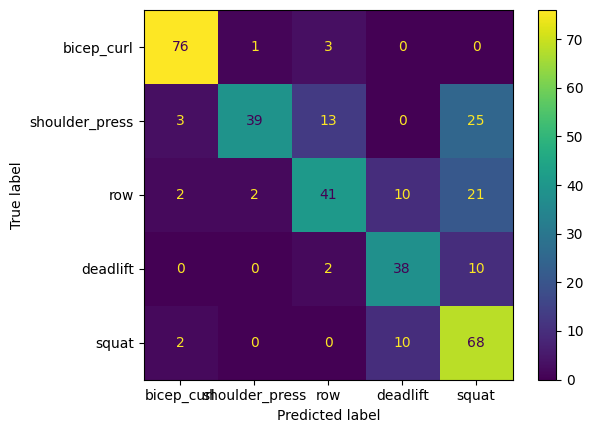

In [8]:
model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

model.load_weights(checkpoint_filepath)

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [9]:
cnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, kernel_size=7, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Conv1D(256, kernel_size=3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 94, 64)         │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,869 (706.52 KB)

 Trainable params: 179,973 (703.02 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6399 - loss: 0.8984 - val_accuracy: 0.1333 - val_loss: 1.5370
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8476 - loss: 0.4636 - val_accuracy: 0.3467 - val_loss: 1.4754
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9030 - loss: 0.3020 - val_accuracy: 0.4267 - val_loss: 1.4537
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9280 - loss: 0.2420 - val_accuracy: 0.4667 - val_loss: 1.4122
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9529 - loss: 0.1531 - val_accuracy: 0.4133 - val_loss: 1.3753
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9501 - loss: 0.1575 - val_accuracy: 0.4133 - val_loss: 1.4544
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9418 - loss: 0.1879 - val_accuracy: 0.4667 - val_loss: 1.4515
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9778 - loss: 0.1124 - val_accuracy: 0.

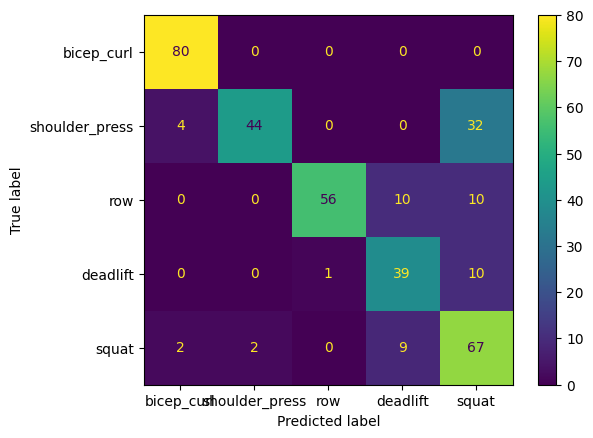

In [10]:
cnn_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# cnn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [11]:
hybrid_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    Conv1D(64, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 96, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,045 (1.43 MB)

 Trainable params: 374,917 (1.43 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6427 - loss: 1.1242 - val_accuracy: 0.2933 - val_loss: 1.4077
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 188s 17s/step - accuracy: 0.8338 - loss: 0.4854 - val_accuracy: 0.2933 - val_loss: 1.4885
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ -186s 105ms/step - accuracy: 0.9224 - loss: 0.2704 - val_accuracy: 0.2533 - val_loss: 1.8420
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9751 - loss: 0.1123 - val_accuracy: 0.2933 - val_loss: 1.9637
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9612 - loss: 0.1113 - val_accuracy: 0.3867 - val_loss: 1.8742
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9668 - loss: 0.1028 - val_accuracy: 0.4267 - val_loss: 1.7142
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9695 - loss: 0.1018 - val_accuracy: 0.4267 - val_loss: 2.0432
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.9778 - loss: 0.0638 - val_a

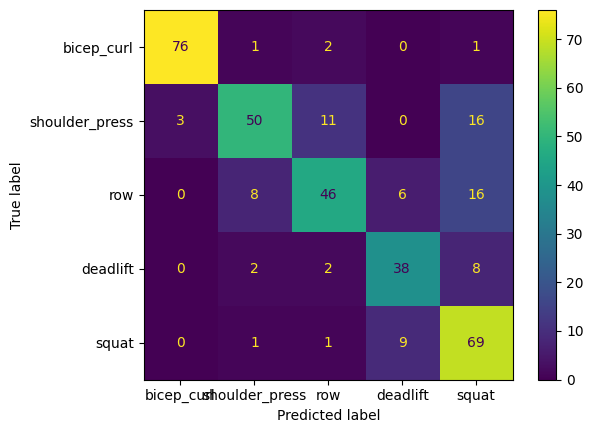

In [12]:
hybrid_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# hybrid_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(hybrid_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [13]:
tcn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=64, kernel_size=5, dropout_rate=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tcn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn (TCN)                       │ (None, 64)             │       231,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,069 (937.77 KB)

 Trainable params: 240,069 (937.77 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
tcn_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.2355 - loss: 5.7339 - val_accuracy: 0.4000 - val_loss: 1.4654
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.3657 - loss: 1.8750 - val_accuracy: 0.4133 - val_loss: 1.4596
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5208 - loss: 1.2066 - val_accuracy: 0.3733 - val_loss: 1.6177
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5485 - loss: 1.0633 - val_accuracy: 0.4133 - val_loss: 1.5331
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6205 - loss: 0.8798 - val_accuracy: 0.4267 - val_loss: 1.5484
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6676 - loss: 0.7657 - val_accuracy: 0.4533 - val_loss: 1.6789
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7175 - loss: 0.6877 - val_accuracy: 0.4400 - val_loss: 1.6045
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7756 - loss: 0.6059 - val_accuracy: 0.4400 - 

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
y_pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 4 0 4 4 0 4 1 2 1 0 1 4 4 1 1 1 1 4 1 1 1 1 1 1 1 4 1 1
 1 1 1 4 1 1 1 4 1 0 0 1 4 1 1 1 4 4 4 1 1 1 4 1 4 4 1 4 1 2 1 1 1 4 1 1 4
 2 2 2 4 4 2 2 2 4 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 2 3 2
 2 4 4 4 4 4 4 4 2 4 4 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 2 2 4 1 2 4 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 1 4 3 2 2
 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 3 3 4 4 4 4 4 4 4 4 4 4
 0 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1
 4 4 4 4 4 4 4 4 4 4 4 4 0 4 4 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4]
y_true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

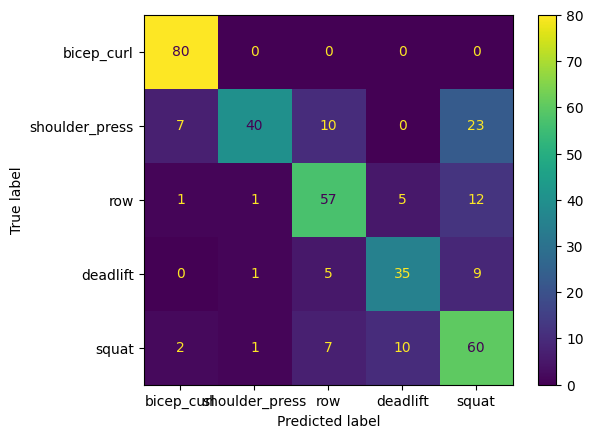

In [15]:
# tcn_model(np.zeros((1, X_train.shape[1], X_train.shape[2])))
# tcn_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(tcn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [16]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = MultiHeadAttention(num_heads=4, key_dim=32)(input_layer, input_layer)
x = LayerNormalization()(x)

x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

transformer_model = tf.keras.Model(input_layer, output)

transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 13)   │      7,053 │ input_layer_4[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 13)   │         26 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 100, 128)  │      1,792 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 5)         │        645 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,516 (37.17 KB)

 Trainable params: 9,516 (37.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.3878 - loss: 1.4205 - val_accuracy: 0.3067 - val_loss: 1.4205
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6011 - loss: 1.0146 - val_accuracy: 0.3333 - val_loss: 1.3971
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6593 - loss: 0.8337 - val_accuracy: 0.3467 - val_loss: 1.4270
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7091 - loss: 0.7031 - val_accuracy: 0.3333 - val_loss: 1.4751
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6731 - loss: 0.6727 - val_accuracy: 0.3467 - val_loss: 1.5354
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7036 - loss: 0.6189 - val_accuracy: 0.3600 - val_loss: 1.5418
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7064 - loss: 0.6178 - val_accuracy: 0.3733 - val_loss: 1.6017
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s -16949318us/step - accuracy: 0.7618 - loss: 0.5627 - val_accuracy: 0.3

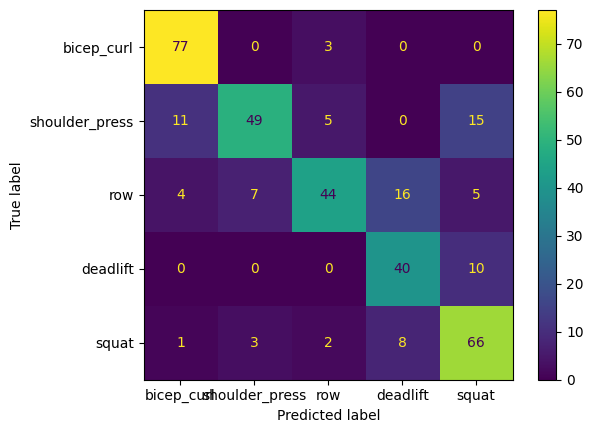

In [17]:
transformer_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# transformer_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(transformer_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [18]:
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    GRU(128, return_sequences=True),
    Dropout(0.3),

    GRU(64),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 128)       │        54,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,645 (377.52 KB)

 Trainable params: 96,645 (377.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.4211 - loss: 1.4324 - val_accuracy: 0.2800 - val_loss: 1.4398
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.6066 - loss: 1.0183 - val_accuracy: 0.2133 - val_loss: 1.4632
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6648 - loss: 0.7983 - val_accuracy: 0.2533 - val_loss: 1.7325
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.7147 - loss: 0.6735 - val_accuracy: 0.2667 - val_loss: 1.8514
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.7729 - loss: 0.5394 - val_accuracy: 0.3067 - val_loss: 2.1509
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s -16847837us/step - accuracy: 0.7922 - loss: 0.4785 - val_accuracy: 0.3067 - val_loss: 2.4239
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8283 - loss: 0.3971 - val_accuracy: 0.2933 - val_loss: 2.7329
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8476 - loss: 0.3564 - val_accura

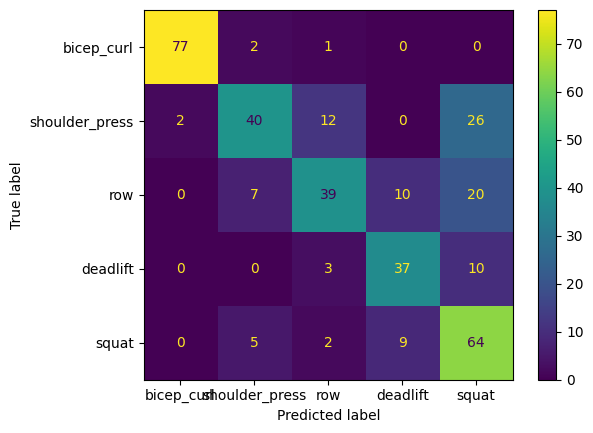

In [19]:
gru_model.fit(
    X_train, y_train,
    validation_split=0.17,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[model_checkpoint_callback]
)

# gru_model.load_weights(checkpoint_filepath)

y_pred = np.argmax(gru_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

print(f"y_pred: {y_pred}")
print(f"y_true: {y_true}")

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

print(cm)
class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names) # class_names are optional
disp.plot()
plt.show()

In [20]:
from sklearn.model_selection import KFold

models = [model, cnn_model, hybrid_model, tcn_model, gru_model, transformer_model]
model_names = ["model", "cnn_model", "hybrid_model", "tcn_model", "gru_model", "transformer_model"]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_accuracies = np.zeros(len(models))

X = X_train
y = y_train

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    for i, model in enumerate(models):
        # You need to re-initialize or clone models here if training from scratch
        # Or retrain your models if they require it, e.g. model.fit(X_train, y_train)
        
        # For demonstration, assuming models are already trained, just predict:
        val_pred_probs = model.predict(X_val)
        val_pred_labels = np.argmax(val_pred_probs, axis=1)
        y_val_labels = np.argmax(y_val, axis=1)
        
        acc = (val_pred_labels == y_val_labels).mean()
        val_accuracies[i] += acc

# Average accuracies across folds
val_accuracies /= kf.get_n_splits()

# Normalize to get weights
weights = val_accuracies / val_accuracies.sum()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ -0s -10658us/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Best accuracy: 0.8033
Best model combination: ['model', 'cnn_model']
y_pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 1 4 1 4 1 4 4 4 4 0 4 0 1 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 4 4 4 1 1 4 4 4 4 1 1 1 1 1 1 1 1 4 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4
 0 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1
 4 4

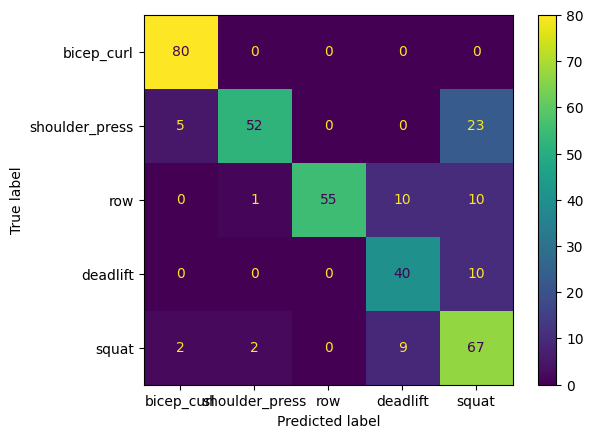

In [21]:
from itertools import combinations

# Ensemble method
# See if taking the average predictions of several models gives us a better result

best_acc = 0
best_combo = None
best_y_pred = None

# Get model predictions upfront
models = [model, cnn_model, hybrid_model, tcn_model, gru_model, transformer_model]
model_names = ["model", "cnn_model", "hybrid_model", "tcn_model", "gru_model", "transformer_model"]
all_preds = [m.predict(X_test) for m in models]
weighted_preds = [pred * weight for weight, pred in zip(weights, all_preds)]

# Iterate through every possible combination, excluding empty combination
for r in range(1, len(models)+1):
    for combo_indices in combinations(range(len(models)), r):

        # Get the average prediction across current ensemble of models
        preds_to_average = np.array([all_preds[i] for i in combo_indices])
        ensemble_preds = np.mean(preds_to_average, axis=0)

        # Get the best predictions
        y_pred = np.argmax(ensemble_preds, axis=1)
        y_true = np.argmax(y_test, axis=1)

        acc = accuracy_score(y_true, y_pred)

        # If we have a new highest accuracy, save that ensemble
        if acc > best_acc:
            best_acc = acc
            best_combo = combo_indices
            best_y_pred = y_pred

print(f"Best accuracy: {best_acc:.4f}")
print("Best model combination:", [model_names[i] for i in best_combo])

y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, best_y_pred)

print(f"y_pred: {best_y_pred}")
print(f"y_true: {y_true}")
print("Classification Report:\n", classification_report(y_true, best_y_pred))
print(cm)

class_names = ["bicep_curl", "shoulder_press", "row", "deadlift", "squat"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()
